In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

prices = pd.read_excel('data/generated_average_prices.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

According to 'The Demand for Expert Opinion: Bordeaux Wine', some important factors are:
- Age of Wine
- Average temperature in the summer (Apr-Sep)
- Harvest rain (Aug-Sep)
- Winter rain (Oct-Mar)

We are going to try and recreate the results of the regression that was run in the paper.

# Feature engineering - recreating the Ashenfelter experiment

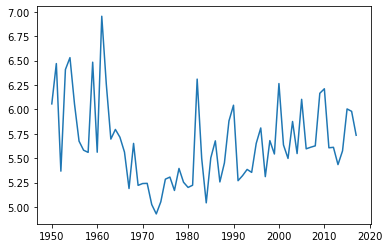

In [10]:
y = prices.set_index('Vintage', drop=True)[['Log Price']]
sns.lineplot(data=y['Log Price'])
plt.show()

In [11]:
X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12

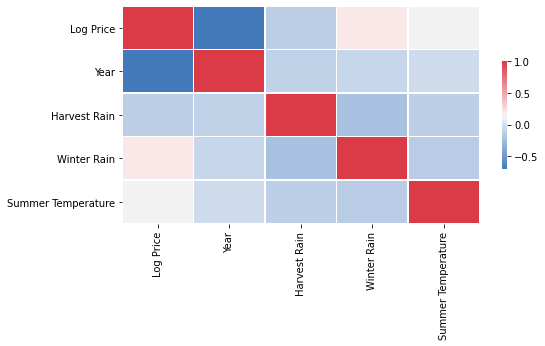

In [12]:
oldest_vintage=1950
newest_vintage=1980
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)
corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

## Building the model

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(normalize=False)
oldest_vintage=1950
newest_vintage=1980

y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X_ex, y_ex)
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[i])
print('Model Score: ',model.score(X_ex,y_ex))

Year -0.0388968218823763
Harvest Rain -0.0012086551317579987
Winter Rain 0.0005620921563760743
Summer Temperature 0.0818143206324637
Model Score:  0.5543329688907064


This score is quite good, but not as impressive as in the first experiment. This could be due to several factors: the prices were not gathered the same way, the corpus of wines is different, the prices have changed since the experiment. Let us now try to see how this modelss result have changed over time.

In [14]:
from sklearn.preprocessing import StandardScaler

def model_tester(X, y):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for column in coefficients:
        oldest_vintage = column
        newest_vintage = column + 30

        y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()

        model.fit(X_ex,y_ex)
        coefs = pd.Series(model.coef_)
        coefs.index = coefficients.index
        coefficients[column] = coefs
        scores.append(model.score(X_ex,y_ex))
    
    coefficients = coefficients.transpose()
    display(coefficients.head())
    return coefficients, scores


#We will need ticks correspoding to our rolling windows for the graphs
labels = [str(i)+'-'+str(i+30) for i in range(1950,1986,5)]

,Year,Harvest Rain,Winter Rain,Summer Temperature
1950,-0.038897,-0.082477,0.075571,0.090416
1951,-0.034253,-0.051905,0.139167,0.197106
1952,-0.032701,-0.056693,0.125759,0.203625
1953,-0.039076,-0.043440,0.145294,0.260175
1954,-0.038089,-0.052644,0.148251,0.262754


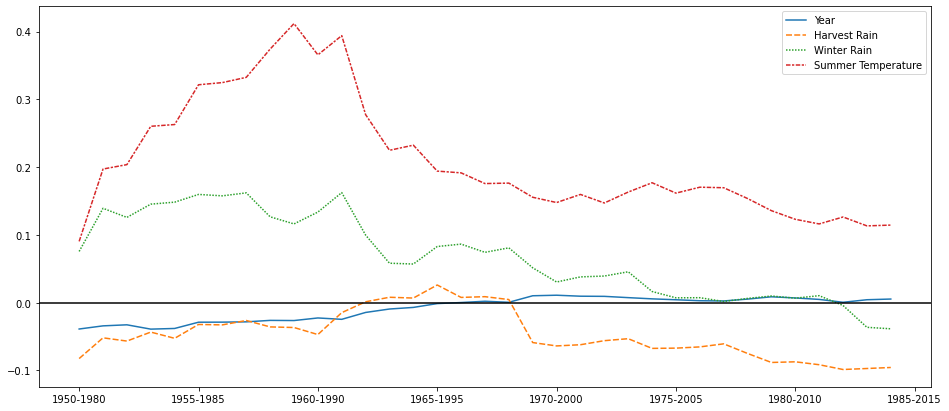

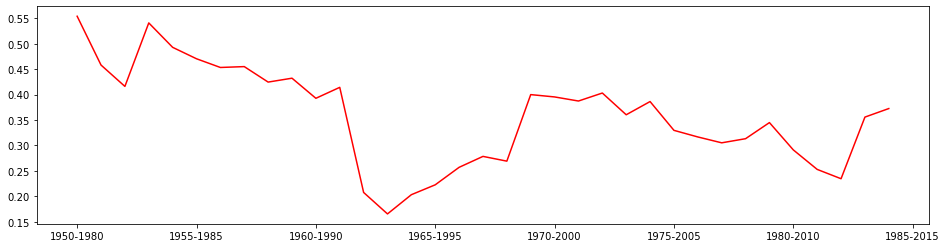

Average score over the whole period:  0.35887118607725366


In [15]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Adding new variables

In [16]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] = precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou'] + precipitations['Sep']
X['Spring Rain'] = precipitations['Mar']+precipitations['Avr']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Insulation'] = insulation.iloc[:,0]

X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])+\
    (temp_maximals['Mar'] + temp_minimals['Mar'])
X['Early Summer Temperature'] = \
    (temp_maximals['Avr'] + temp_minimals['Avr']) +\
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui']) +\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])

X['Frost Days Winter'] = frost_days.shift(1)['Nov']+frost_days.shift(1)['Dec'] + frost_days['Jan']
X['Frost Days Early'] = frost_days['Fev']+frost_days['Mar']
X['Frost Days Late'] = frost_days['Avr']+ 2*(frost_days['Mai'] + frost_days['Jui'] + frost_days['Juil'])

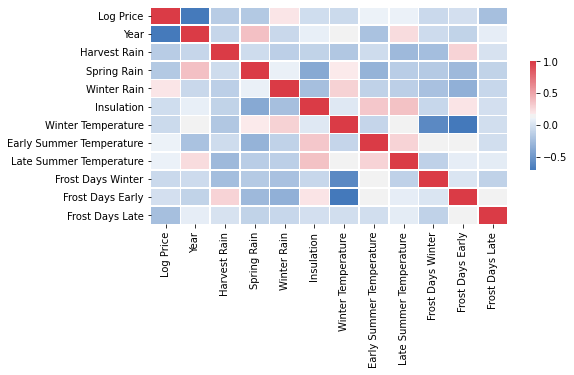

In [17]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

,Year,Harvest Rain,Spring Rain,Winter Rain,Insulation,Winter Temperature,Early Summer Temperature,Late Summer Temperature,Frost Days Winter,Frost Days Early,Frost Days Late
1950,-0.043663,-0.098170,0.036993,0.058932,0.013862,-0.307023,-0.060185,0.239586,-0.220135,-0.163132,-0.076913
1951,-0.033463,-0.103063,-0.039779,0.065277,-0.029122,-0.439005,0.071251,0.207029,-0.366508,-0.266996,-0.104280
1952,-0.033356,-0.104551,-0.042039,0.054210,-0.012852,-0.426049,0.058906,0.197321,-0.355051,-0.267690,-0.100752
1953,-0.039524,-0.122316,-0.022474,0.072571,-0.082847,-0.233289,0.188682,0.143150,-0.232910,-0.151223,-0.071123
1954,-0.037027,-0.124000,-0.016986,0.055746,-0.056653,-0.295571,0.174222,0.138088,-0.282595,-0.192161,-0.075475


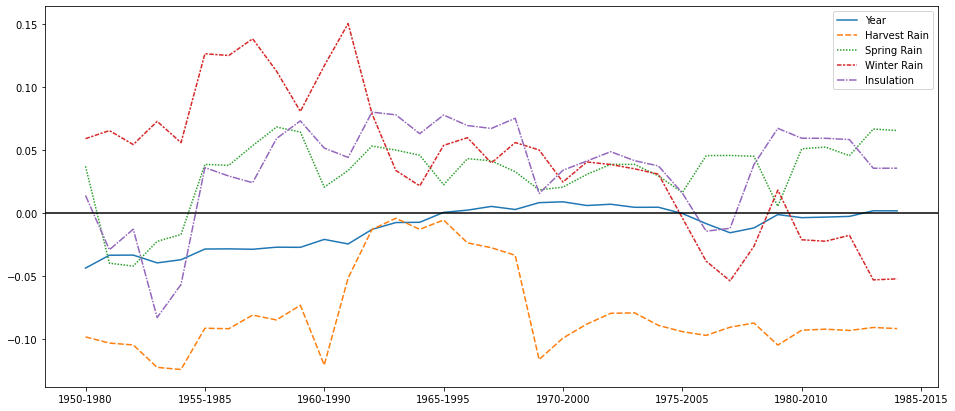

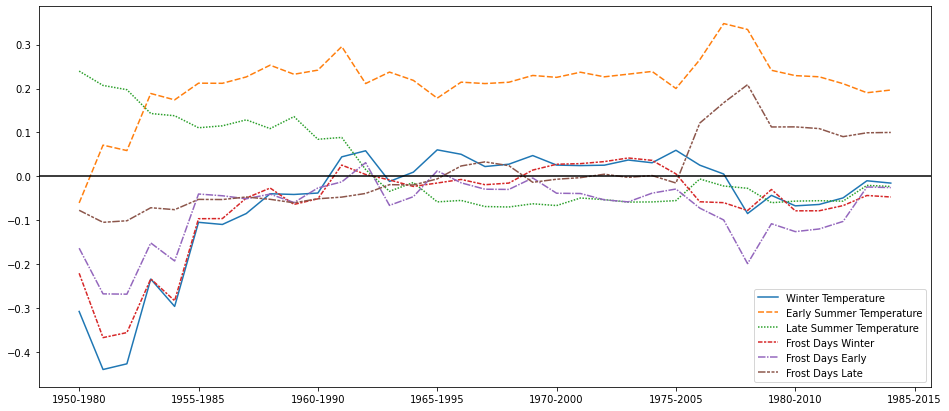

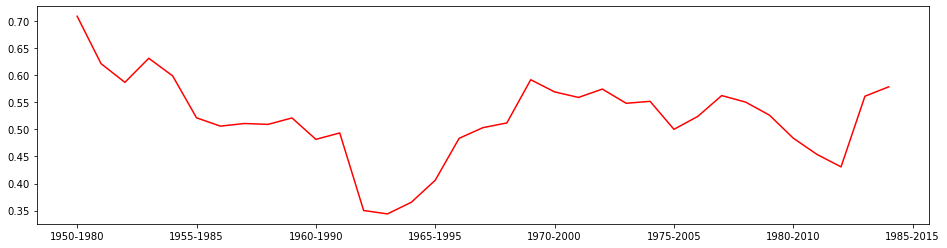

Average score over the whole period:  0.5206676896635248


In [18]:
coefficients, scores = model_tester(X,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

This is better, but there is too many features: 11 features for predicting a 30 dimensional vector.
Let us rank the features according to their average importance.

In [19]:
from sklearn.metrics import r2_score

display(y)
for column in X.columns:
    print(r2_score(y.loc[1950:2015, 'Log Price'].values, X.loc[1950:2015, column].values))

,Log Price
Vintage,
1950,6.056394
1951,6.469423
1952,5.367075
1953,6.408163
1954,6.530347
...,...
2013,5.434236
2014,5.574834
2015,6.004613


-650093.94703132
-116546.83900980932
-1705539.7031715836
-24303076.720233735
-17052.637338141998
-92457.77841614427
-29274.857942441475
-1611.0604256667614
-525.4274594917565
-146.49044005391477


# Improved model

In [20]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2

X['Winter Rain'] =  precipitations.shift(1)['Dec']

#X['Winter Temperature'] = \
#    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
#    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
#    (temp_maximals['Fev'] + temp_minimals['Fev'])


X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Square Summer Temperature'] = X['Summer Temperature']**2

X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2

X['Square Harvest Temperature'] = X['Harvest Temperature']**2

X['Frost Days'] = frost_days['Mar']+ 2*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])
##X['Insulation'] = insulation.iloc[:,0]


,Year,Harvest Rain,Winter Rain,Summer Temperature,Square Summer Temperature,Harvest Temperature,Square Harvest Temperature,Frost Days
1950,-0.046552,-0.020984,-0.027544,-1.676588,1.677464,-3.027929,3.592979,-0.012789
1951,-0.039172,-0.019634,0.091607,-2.913297,3.059988,-2.245857,2.757066,-0.021756
1952,-0.036694,-0.026559,0.080238,-2.884223,3.041458,-2.386029,2.913029,-0.031792
1953,-0.038359,-0.041542,0.079448,-2.611115,2.822350,-2.829624,3.304606,-0.037054
1954,-0.036820,-0.036929,0.067949,-2.453563,2.657668,-3.244156,3.753154,-0.036115


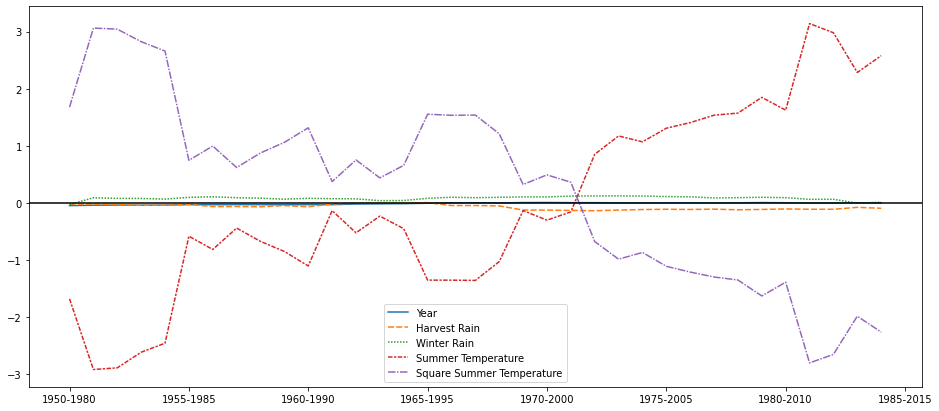

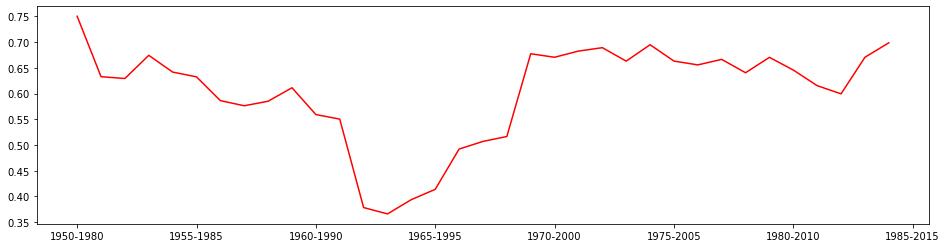

Average score over the whole period:  0.6028414144821397


In [21]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Can it predict prices?

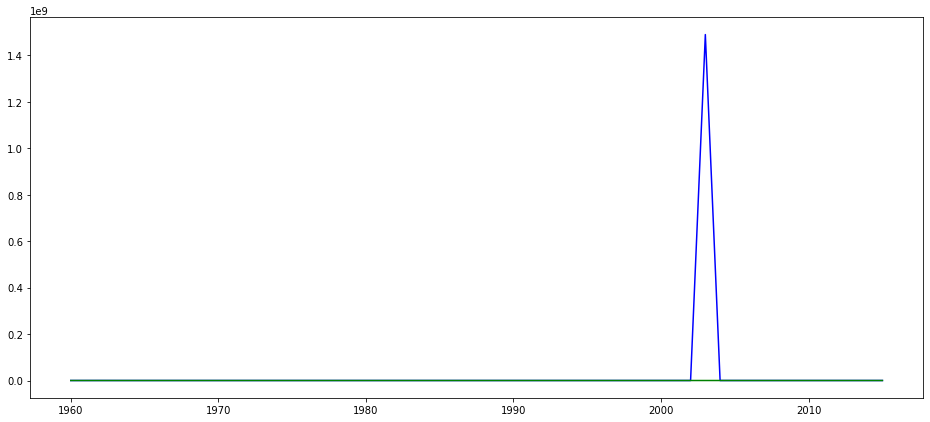

In [22]:
def reg_predict(X,y, window_length):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    predictions = []

    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for target_vintage in range(1950+window_length,2016):
        oldest_vintage = target_vintage - window_length
        newest_vintage = target_vintage

        y_ex = y.loc[oldest_vintage:newest_vintage-1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage-1,:].reset_index()
        model.fit(X_ex,y_ex)

        target = np.array([target_vintage]+X.loc[target_vintage,:].to_list()).reshape(1,-1)
        prediction = model.predict(target)
        predictions.append(prediction)
    return predictions
    
window_length = 10
plt.figure(figsize=(16,7))
plt.plot(range(1950+window_length,2016), np.exp(reg_predict(X,y, window_length)), color='blue')
sns.lineplot(data=np.exp(y.loc[1950+window_length:2015,'Log Price']), color='green')
plt.show()

Let us compare the r2 score of our model, regression with a window of width n against the r2 score of a simple model that draws a regression line on the last n prices and simply continues that line to predict the next price.

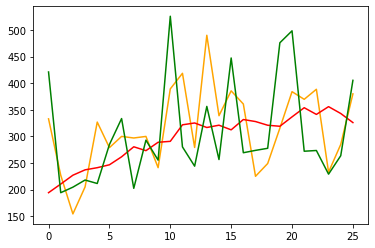

[-5.693712839946857, -0.810112128264789, -0.5471381782260158, -0.49672595461756175, -0.467967443881141, -0.4678644467883155, -0.14689008600009612, -0.1688771735882666, -0.09057492507350973, 0.17724244149207435, 0.09706924784378645, 0.22523618932782563, 0.148892847991154, 0.16290218251193977, 0.22475966739074693, 0.13656724702937872, 0.23256707219554051, 0.24380167847117462, 0.16824872256148637, 0.15353927578910054, 0.18998823505157003, 0.21814123665247553, 0.11910458598916662, -0.047053149174804965, -0.07633143740111348, -0.09912538912648983, -0.09671150182776844, -0.09789089099589354]


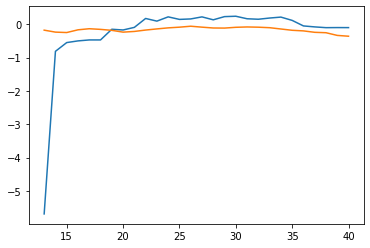

Maximal score:  0.24380167847117462


In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scores=[]
other_scores=[]
line_regressor = LinearRegression()

for window_length in range(13,41,1):
    prediction = np.exp(reg_predict(X,y, window_length))
    prediction = np.array(prediction.reshape(1,-1).tolist()[0][-26:]).reshape(1,-1)[0]
    actual_prices = np.exp(y.loc[1990:2015,'Log Price']).values

    line_model_predictions = np.zeros_like(actual_prices)
    
    for vintage in range(1990,2016):
        X_ex = np.array(X.loc[(vintage - window_length):(vintage -1)].index.to_list()).reshape(-1,1)
        y_ex = y.loc[(vintage - window_length):(vintage -1),'Log Price']
        line_regressor.fit(X_ex, y_ex)
        target = np.array([vintage]).reshape(1,-1)
        line_model_predictions[vintage-1990] = line_regressor.predict(target)

    line_model_predictions = np.exp(line_model_predictions)
    if window_length==30:
        plt.plot(prediction, color='orange')
        plt.plot(line_model_predictions, color='red')
        plt.plot(actual_prices, color='green')
        plt.show()
    scores.append(r2_score(actual_prices, prediction))
    other_scores.append(r2_score(actual_prices, line_model_predictions))

print(scores)
plt.plot(range(13,41,1),scores)
plt.plot(range(13,41,1),other_scores)

plt.show()
print('Maximal score: ',max(scores))

According to the results, let us keep a window length of 30.
Now, try to quantify the predictive performance of this algo across the last 50 years.

36


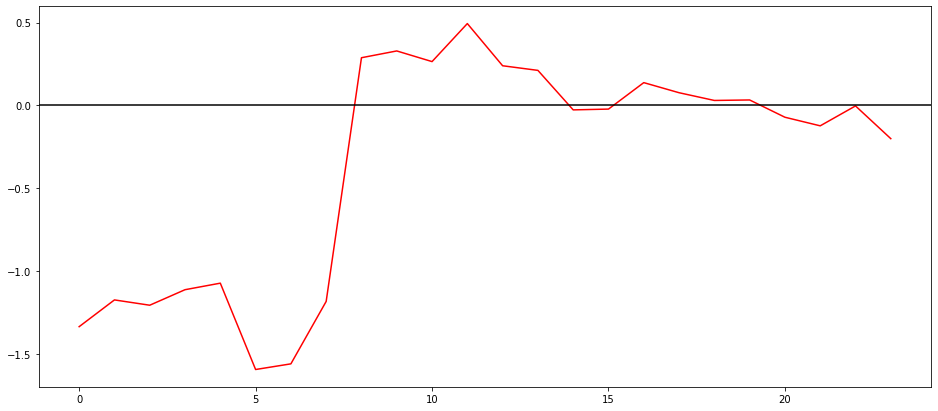

36 -0.25587728078117866


In [39]:
window_length=30

predictions = np.exp(reg_predict(X,y, window_length))
actual_prices = np.exp(y.loc[1980:2015,'Log Price']).values
print(len(predictions))
r2_scores=[]
for i in range(24):
    r2_scores.append(r2_score(actual_prices[i:(i+10)],predictions[i:(i+10)]))

plt.figure(figsize=(16,7))
sns.lineplot(x=range(24), y=r2_scores, color='red').axhline(0., color='black')
plt.show()

print(len(predictions), r2_score(actual_prices, predictions))

# Appendix: Trying PCA

In [16]:
X = pd.concat([precipitations, insulation, temp_maximals, temp_minimals, frost_days], axis=1)

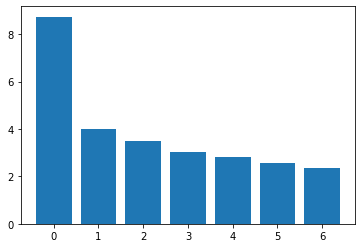

[[ 4.46731803e-02  5.17589182e-02  7.68975089e-02 -5.94249058e-02
   4.73626417e-02 -9.28140490e-05  3.89596387e-02  4.22997508e-02
   2.11402361e-02 -3.24997756e-02 -6.72006048e-02 -3.41858928e-02
  -4.45703682e-02 -9.89856327e-02 -1.30640072e-01 -2.14537934e-01
  -1.44879073e-01 -2.01771935e-01 -1.98760278e-01 -1.54932170e-01
  -2.21329116e-01 -1.16302429e-01 -1.27579706e-01 -1.61126725e-01
  -1.48999490e-01 -9.60686408e-02 -1.02811949e-01 -1.91734605e-01
  -2.28765688e-01 -2.36043014e-01 -2.70261378e-01 -2.32894443e-01
  -2.62187309e-01 -1.65548932e-01 -2.12939355e-01 -2.03097049e-01
  -1.64632403e-01  4.87585185e-02  8.96034355e-02  1.99039602e-01
   1.74983299e-01  3.54514845e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.97248813e-02  1.98930833e-01
   1.39014013e-01]
 [-3.33357461e-01 -2.06877894e-01 -2.04343223e-01 -3.04329665e-02
  -2.49417976e-01  3.01271698e-02  1.50322150e-01 -4.12779228e-03
   1.44561801e-02  1.52068639e-01  3.15252123e-02  3.4539

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

,Year,0,1,2,3,4,5,6
1950,-0.036389,-0.501392,-0.009124,0.146862,0.100450,0.001130,-0.157836,-0.184378
1951,-0.029024,-0.660683,-0.012283,0.281371,0.061706,0.045545,-0.121058,-0.288059
1952,-0.024487,-0.723280,0.040373,0.245524,0.085576,0.028595,-0.178248,-0.275953
1953,-0.031473,-0.725926,-0.013252,0.284363,0.056683,0.052937,-0.155507,-0.232192
1954,-0.028589,-0.666948,0.014285,0.222433,0.033778,0.085558,-0.219604,-0.171506


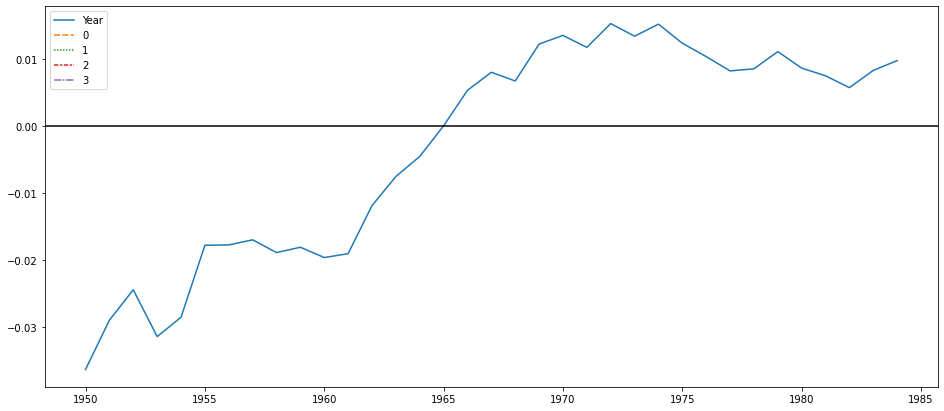

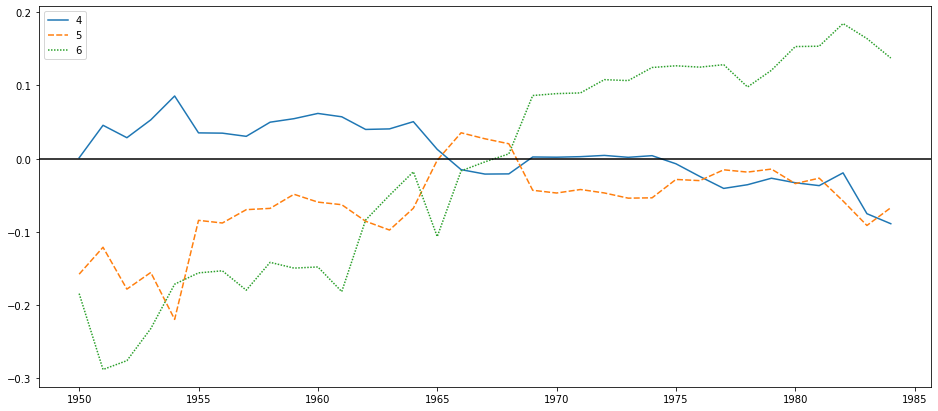

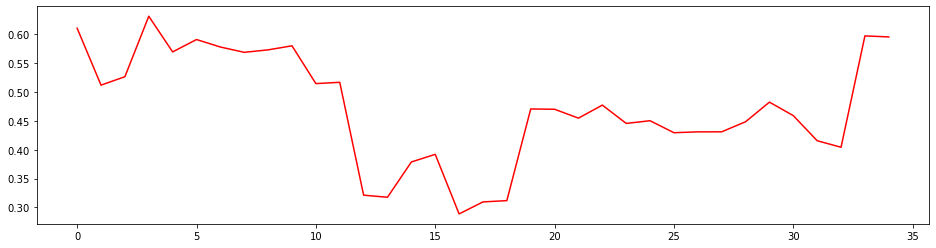

Average score over the whole period:  0.47302570406415195


In [18]:
coefficients, scores = model_tester(X2,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))

PCA doesn't give good enough results, provided that it makes us lose track of the variables' meanings. We will not use it.